# Customer Segmentation using KMeans - You Are What You Eat!

In this project we use k-means clustering to segment up the customer base in order to increase business understanding, and to enhance the relevancy of targeted messaging & customer communications.

# Table of contents

- [00. Project Overview](#overview-main)
    - [Context](#overview-context)
    - [Actions](#overview-actions)
    - [Results](#overview-results)
- [01. Data Preparation](#data-prep)
- [02. K-Means](#k-means)
    - [Concept Overview](#kmeans-overview)
    - [Data Preprocessing](#data-prep)
    - [Finding A Good Value For K](#finding-best-k)
    - [Model Fitting and Results](#model-fitting)
- [03. Application](#kmeans-application)
- [04. Growth & Next Steps](#growth-next-steps)

___

# Project Overview  <a name="overview-main"></a>

### Context <a name="overview-context"></a>

The Senior Management team from our client, a supermarket chain, are disagreeing about how customers are shopping, and how lifestyle choices may affect which food areas customers are shopping into, or more interestingly, not shopping into.

They have asked us to use data, and Machine Learning to help segment up their customers based upon their engagement with each of the major food categories - aiding business understanding of the customer base, and to enhance the relevancy of targeted messaging & customer communications.

<br>

### Actions <a name="overview-actions"></a>

We firstly needed to compile the necessary data from sevaral tables in the database, namely the *transactions* table and the *product_areas* table.  We joined together the relevant information using Pandas, and then aggregated the transactional data across product areas, from the most recent six month to a customer level.  The final data for clustering is, for each customer, the percentage of sales allocated to each product area.

As a starting point, we test & apply k-means clustering for this task.  We need to apply some data pre-processing, most importantly feature scaling to ensure all variables exist on the same scale - a very important consideration for distance based algorithms such as k-means.

As k-means is an *unsupervised learning* approach, in other words there are no labels - we use a process known as *Within Cluster Sum of Squares (WCSS)* to understand what a "good" number of clusters or segments is.

Based upon this, we apply the k-means algorithm onto the product area data, append the clusters to our customer base, and then profile the resulting customer segments to understand what the differentiating factors were!
<br>
<br>

### Results <a name="overview-results"></a>

Based upon iterative testing using WCSS we settled on a customer segmentation with 3 clusters.  These clusters ranged in size, with Cluster 0 accounting for 73.6% of the customer base, Cluster 2 accounting for 14.6%, and Cluster 1 accounting for 11.8%.

There were some extremely interesting findings from profiling the clusters.

For *Cluster 0*, we saw a significant portion of spend being allocated to each of the product areas - showing customers without any particular dietary preference.  

For *Cluster 1*, we saw quite high proportions of spend being allocated to Fruit & Vegetables, but very little to the Dairy & Meat product areas.  It could be hypothesised that these customers are following a vegan diet.  

Finally customers in *Cluster 2* spent significant portions within Dairy, Fruit & Vegetables, but very little in the Meat product area - so similarly, we would make an early hypothesis that these customers are more along the lines of those following a vegetarian diet.


# Data Preparation <a name="data-prep"></a>

In [71]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

In [4]:
transactions = pd.read_excel('C:/Users/Ibiene/OneDrive/DataScience_MachineLearning/Data Science Infinity/Machine Learning/Model Building/data/grocery_database.xlsx', sheet_name = 'transactions')
product_areas = pd.read_excel('C:/Users/Ibiene/OneDrive/DataScience_MachineLearning/Data Science Infinity/Machine Learning/Model Building/data/grocery_database.xlsx', sheet_name = 'product_areas')

In [5]:
transactions.sample(2)

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
26149,591,2020-06-16,436324920340,1,3,74.01
17863,392,2020-05-27,436122533405,3,12,27.51


In [6]:
product_areas.sample(2)

,product_area_id,product_area_name,profit_margin
2,3,Fruit,0.14
4,5,Meat,0.11


In [7]:
transactions = pd.merge(transactions, product_areas, how = "inner", on = 'product_area_id')

In [8]:
transactions.head(10)

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost,product_area_name,profit_margin
0,1,2020-04-10,435657533999,3,7,19.16,Fruit,0.14
1,1,2020-07-20,436667313620,3,8,19.99,Fruit,0.14
2,1,2020-07-22,436686191960,3,20,61.69,Fruit,0.14
3,1,2020-08-12,436899350757,3,16,52.28,Fruit,0.14
4,1,2020-08-13,436908803653,3,14,34.58,Fruit,0.14
5,1,2020-08-14,436913894011,3,21,63.31,Fruit,0.14
6,1,2020-08-28,437054306208,3,6,24.99,Fruit,0.14
7,2,2020-04-15,435703814216,3,13,44.57,Fruit,0.14
8,2,2020-06-19,436357605508,3,5,10.27,Fruit,0.14
9,2,2020-06-22,436389036591,3,12,24.68,Fruit,0.14


In [9]:
transactions.shape

(38506, 8)

In [10]:
transactions.product_area_name.value_counts()

Fruit         8699
Vegetables    8473
Non-Food      7784
Dairy         7360
Meat          6190
Name: product_area_name, dtype: int64

In [11]:
transactions = transactions[transactions.product_area_name != 'Non-Food']

# the problem statement is focused on customer segmentation using dietary and lifestyle 

In [12]:
transactions.shape

(30722, 8)

In [13]:
transactions_summary = transactions.groupby(["customer_id", "product_area_name"]).sales_cost.sum().reset_index()
transactions_summary

,customer_id,product_area_name,sales_cost
0,1,Dairy,367.74
1,1,Fruit,276.00
2,1,Meat,543.38
3,1,Vegetables,167.12
4,2,Dairy,150.63
...,...,...,...
3151,869,Vegetables,168.85
3152,870,Dairy,247.97
3153,870,Fruit,322.90
3154,870,Meat,284.26


In [14]:
# pivot data to place product areas as columns
transaction_summary_pivot = transactions.pivot_table(index = 'customer_id', 
                                                   columns = 'product_area_name', 
                                                   values = 'sales_cost', 
                                                   aggfunc = 'sum', 
                                                   fill_value = 0, 
                                                   margins = True, 
                                                   margins_name = "Total").rename_axis(None, axis = 1)

In [15]:
transaction_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,367.74,276.00,543.38,167.12,1354.24
2,150.63,120.93,241.21,99.05,611.82
3,46.20,75.39,171.13,31.50,324.22
4,341.91,245.36,272.79,142.35,1002.41
5,694.71,815.32,1405.19,350.10,3265.32
...,...,...,...,...,...
867,129.84,176.73,180.49,88.83,575.89
868,225.59,358.89,343.26,189.24,1116.98
869,126.28,127.50,183.88,168.85,606.51


In [52]:
#turn sales into percentages, axis = 0 means operation is to be carried out on rows
transaction_summary_pivot = transaction_summary_pivot.div(transaction_summary_pivot.Total, axis =0)


In [53]:
transaction_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,1.0
2,0.246200,0.197656,0.394250,0.161894,1.0
3,0.142496,0.232527,0.527821,0.097156,1.0
4,0.341088,0.244770,0.272134,0.142008,1.0
5,0.212754,0.249691,0.430338,0.107218,1.0
...,...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248,1.0
868,0.201964,0.321304,0.307311,0.169421,1.0
869,0.208208,0.210219,0.303177,0.278396,1.0


In [54]:
#drop the total column

data_for_clustering = transaction_summary_pivot.drop(['Total'], axis = 1)

In [55]:
data_for_clustering.head(3)

,Dairy,Fruit,Meat,Vegetables
customer_id,,,,
1,0.271547,0.203804,0.401244,0.123405
2,0.246200,0.197656,0.394250,0.161894
3,0.142496,0.232527,0.527821,0.097156


# K-Means <a name = "k-means"></a>

### Concept Overview <a name="kmeans-overview"></a>

K-Means is an *unsupervised learning* algorithm, meaning that it does not look to predict known labels or values, but instead looks to isolate patterns within unlabelled data.

The algorithm works in a way where it partitions data-points into distinct groups (clusters) based upon their *similarity* to each other.

This similarity is most often the eucliedean (straight-line) distance between data-points in n-dimensional space.  Each variable that is included lies on one of the dimensions in space.

### Data Preprocessing <a name = "data-prep"></a>

There are three vital preprocessing steps for k-means, namely:

* **Missing values in the data**: This can be dealt with by either imputation or simply removing those rows if the percentage of missing values is negligible.
* **The effect of outliers**: Since we are using a distance-based algorithm, the presence of outliers could really skew the results.In this case however, since the clustering data is by percentages per customer, we don't face this issue. 
* **Feature Scaling**: We would be normalizing the data using the MinMax Scaler from the *scikit-learn* library. Normalization means we are forcing the values between 0 and 1, which is even more appropriate in the event that we had to encode categorical variables. 

In [56]:
#check for missing values

data_for_clustering.isna().sum()

Dairy         0
Fruit         0
Meat          0
Vegetables    0
dtype: int64

In [ ]:
# no outliers in the data

In [57]:
# scale data - normalize 

scale_norm = MinMaxScaler()


In [58]:
data_for_clustering_scaled = pd.DataFrame(scale_norm.fit_transform(data_for_clustering), columns = data_for_clustering.columns)

In [59]:
data_for_clustering_scaled.sample(3)

,Dairy,Fruit,Meat,Vegetables
842,0.154391,0.415766,0.427427,0.173349
9,0.315468,0.309491,0.354504,0.189999
644,0.242325,0.310041,0.448106,0.159251


### Finding A Good Value for k <a name="finding-best-k"></a>

The default value for k in the *scikit-learn* KMeans algorithm is 8 which means it will look to split the data into eight distinct clusters; this may not always be appropriate for the specific user data. So it is necessary to investigate an appropriate k to use in our specific task.

The approach we will utilise here is known as *Within Cluster Sum of Squares (WCSS)* which measures the sum of the squared Euclidean distances that data points lie from their closest centroid.  WCSS can help us understand the point where adding *more clusters* provides little extra benefit in terms of separating our data.

In the code below we will test multiple values for k, and plot how this WCSS metric changes.  As we increase the value for k (in other words, as we increase the number or centroids or clusters) the WCSS value will always decrease.  However, these decreases will get smaller and smaller each time we add another centroid and we are looking for a point where this decrease is quite prominent *before* this point of diminishing returns. This is usually called an Elbow plot.

In [72]:
# Use Within Cluster Sum of Sqaures (WCSS) to find a good value for k

k_values = list(range(1, 10))
wcss_list = []

for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(data_for_clustering_scaled)
    wcss_list.append(kmeans.inertia_)
    

C:\Users\Ibiene\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


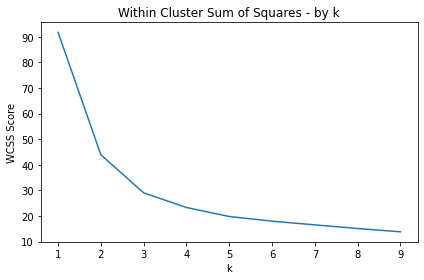

In [61]:
plt.plot(k_values, wcss_list)
plt.title("Within Cluster Sum of Squares - by k")
plt.xlabel("k")
plt.ylabel("WCSS Score")
plt.tight_layout()
plt.show()

### Model Fitting and Results <a name ="model-fitting"></a>

In [62]:
# Instantiate and fit model 

kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(data_for_clustering_scaled)


KMeans(n_clusters=3, random_state=42)

In [63]:
#add cluster labels to data
data_for_clustering['Cluster'] = kmeans.labels_

In [64]:
data_for_clustering

,Dairy,Fruit,Meat,Vegetables,Cluster
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,0
2,0.246200,0.197656,0.394250,0.161894,0
3,0.142496,0.232527,0.527821,0.097156,0
4,0.341088,0.244770,0.272134,0.142008,0
5,0.212754,0.249691,0.430338,0.107218,0
...,...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248,0
868,0.201964,0.321304,0.307311,0.169421,0
869,0.208208,0.210219,0.303177,0.278396,0


In [65]:
# check cluster sizes
data_for_clustering.Cluster.value_counts()

0    641
2    127
1    103
Name: Cluster, dtype: int64

In [66]:
data_for_clustering.Cluster.value_counts(normalize = True)

0    0.735936
2    0.145809
1    0.118255
Name: Cluster, dtype: float64

In [67]:
# profile our clusters by looking at summary statistics - why did the algorithm consider them to be distinct?
cluster_summary = data_for_clustering.groupby('Cluster')[['Dairy', 'Fruit', 'Meat', 'Vegetables']].mean()

In [68]:
#convert to % 

summary_table = round(cluster_summary*100, 2)
summary_table

,Dairy,Fruit,Meat,Vegetables
Cluster,,,,
0,22.09,26.46,37.65,13.80
1,0.24,63.78,0.37,35.61
2,36.39,39.42,2.92,21.27




* For **Cluster 0**, we see that the spend is distributed almost evenly across the various product area categories - showing customers without anyv particular dietary preference.
* For **Cluster 1**, high proportions of spend is being allocated to Fruit & Vegetables, but very little (less than 1%) to the Dairy & Meat product areas. *It could be hypothesised that these customers are following a vegan diet**. 
* Finally customers in **Cluster 2** spend, on average, significant portions within Dairy, Fruit & Vegetables, 
but very little in the Meat product area. So similarly, we would make an *early hypothesis that these customers are more along the lines of those following a vegetarian diet - very interesting!*

Additonally, from the percentage split between the groups, we see that most customers (~ 74%) follow a "regular" diet that is almost evenly distributed across the food groups. Interestingly, that also shows that vegetables sales in this group is lower relative to the other food groups - but that would require *tests of significance* to determine whether this is truly signifcant or random chance. 



## Application
Even though is is a simple solution based upon high level product areas, it will help leaders in the business, and category managers gain a clearer understanding of the customer base.

Tracking these clusters over time would allow the client to more quickly react to dietary trends, and adjust their messaging and inventory accordingly.

Based upon these clusters, the client will be able to target customers more accurately - promoting products & discounts to customers that are truly relevant to them - overall enabling a more customer focused communication strategy.



## Growth & Next Steps
It would be interesting to run this clustering/segmentation at a lower level of product areas, so rather than just the four areas of Meat, Dairy, Fruit, Vegetables - clustering spend across the sub-categories below those categories. This would mean we could create more specific clusters, and get an even more granular understanding of dietary preferences within the customer base.

Here we’ve just focused on variables that are linked directly to sales - it could be interesting to also include customer metrics such as distance to store, gender etc to give a even more well-rounded customer segmentation.

It would be useful to test other clustering approaches such as Hierarchical Clustering or DBSCAN to compare the results.